In [45]:
# This notebook will explore simple models that are made using spatial CV

# Note: code may need some cleaning but got the gist down 

#By Amanda Worthy

In [46]:
#import the packages!!

import os
import time
import requests
import itertools
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
import seaborn as sns
import plotly.express as px
import geopandas as gpd
import fiona
import shapely.geometry
from shapely.geometry import Point, Polygon, box, shape
from affine import Affine
from rasterio.enums import Resampling
import pyproj
from rasterstats import zonal_stats
from sklearn.model_selection import (
    train_test_split,
    GroupKFold,
    LeaveOneOut,
    cross_val_predict
)
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
import itertools


In [47]:
#import the USA file 
usa_fxn = "usa.geojson"

usa = gpd.read_file(usa_fxn)

In [48]:
!ls

Modeling_w_spatial_cv.ipynb
Newest_dataset_analysis_python.ipynb
Tree_ds_sep16.csv
environment.yml
explore_variation_among_same_location.ipynb
spatial_auto_tests.ipynb
usa.geojson


In [49]:
#import the tree dataset 
tree_fxn = "Tree_ds_sep16.csv"

tree= pd.read_csv(tree_fxn)

mygeometry_array = gpd.points_from_xy(tree['Longitude'], tree['Latitude'])

tree= gpd.GeoDataFrame(
tree, crs='EPSG:4326', geometry=mygeometry_array)

#tree.head()

In [50]:
tree = tree[~tree['Region'].isin(['California', 'Washington'])]  #okay we are taking it i guess 

In [51]:
tree.head()

,tree_id,Region,Latitude,Longitude,geometry,Species,Date collected,Type of sample,Height of sample,Diameter of tree at sample location (inches),...,4_tmin_nClimGrid,5_tmin_nClimGrid,6_tmin_nClimGrid,7_tmin_nClimGrid,8_tmin_nClimGrid,9_tmin_nClimGrid,10_tmin_nClimGrid,11_tmin_nClimGrid,12_tmin_nClimGrid,annual_tmin_nClimGrid
0,0,Ohio,41.486318,-81.934554,POINT (-81.93455 41.48632),rubra,01/07/17,disk,NaN,27.5,...,4.721354,11.013965,16.492676,19.165266,18.392643,14.586589,8.672624,2.884961,-1.714681,6.962891
1,1,Michigan,42.667700,-85.449200,POINT (-85.4492 42.6677),sp.,05/03/19,disk,NaN,9.0,...,2.039616,8.190105,13.523373,15.648698,14.951367,10.567318,4.909961,-0.368978,-4.949381,3.741542
2,2,Pennsylvania,40.573010,-75.339340,POINT (-75.33934 40.57301),alba,16/01/19,disk,NaN,9.0,...,3.583561,9.132389,14.309050,17.111622,16.050976,12.029753,5.415690,0.469401,-3.621094,5.051194
3,3,Pennsylvania,41.195420,-75.856400,POINT (-75.8564 41.19542),alba,19/01/19,disk,NaN,8.0,...,0.993945,7.130957,11.748763,14.286361,13.614323,9.920410,3.801302,-1.403646,-5.992969,2.602510
4,4,Michigan,44.560850,-84.608510,POINT (-84.60851 44.56085),alba,20/03/19,disk,1.0,14.0,...,-1.175651,4.913672,10.602083,12.727995,12.056608,7.842708,2.612760,-2.448600,-7.438184,0.787554


In [52]:
states =tree['Region'].values

tree['Region'].unique()

array(['Ohio', 'Michigan', 'Pennsylvania', 'New Hampshire', 'Virginia',
       'Maryland', 'Vermont', 'New York', 'Mississippi', 'West Virginia',
       'Maine', 'Kentucky', 'Tennessee', 'Wisconsin'], dtype=object)

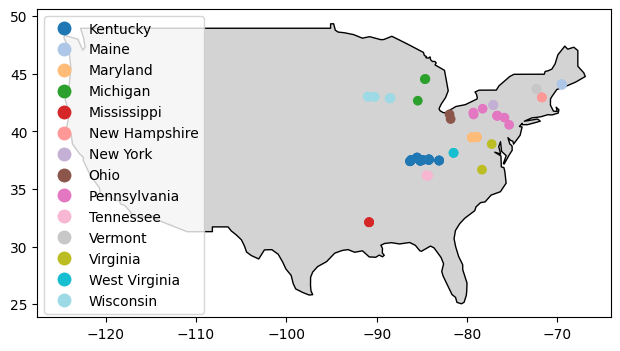

In [53]:
fig, ax = plt.subplots(figsize=(8, 4))
usa.plot(ax = ax, color = 'lightgray', edgecolor = 'black')
tree.plot(column='Region', cmap= 'tab20',  legend=True, ax=ax);


In [54]:

cluster_assignments = {
    'Maine': 'Northeast',
    'New Hampshire': 'Northeast',
    'Vermont': 'Northeast',
    
    'New York': 'New Yorkish',
    'Pennsylvania': 'New Yorkish',
    'Ohio': 'New Yorkish',
    
    'Maryland': 'Capital',
    'West Virginia': 'Capital',
    'Virginia': 'Capital',
    
    'Michigan': 'Midwest',
    'Wisconsin': 'Midwest',
    
    'Kentucky': 'South',
    
    'Tennessee': 'Super South',
    'Mississippi': 'Super South'
}

tree['RegionCluster'] = tree['Region'].map(cluster_assignments)


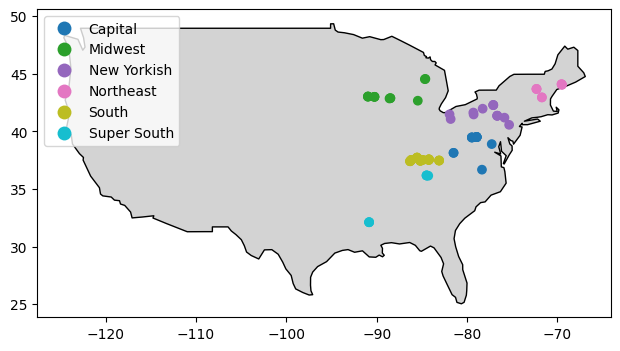

In [55]:
fig, ax = plt.subplots(figsize=(8, 4))
usa.plot(ax = ax, color = 'lightgray', edgecolor = 'black')
tree.plot(column='RegionCluster', cmap= 'tab10',  legend=True, ax=ax);

In [56]:
tree.Region.value_counts()

Region
Kentucky         24
Maryland          9
Wisconsin         9
Pennsylvania      8
Maine             4
Tennessee         4
Michigan          3
Vermont           3
New York          3
Mississippi       3
Ohio              2
New Hampshire     2
Virginia          2
West Virginia     2
Name: count, dtype: int64

In [57]:
tree.RegionCluster.value_counts()

RegionCluster
South          24
New Yorkish    13
Capital        13
Midwest        12
Northeast       9
Super South     7
Name: count, dtype: int64

In [58]:
#list(tree.columns)

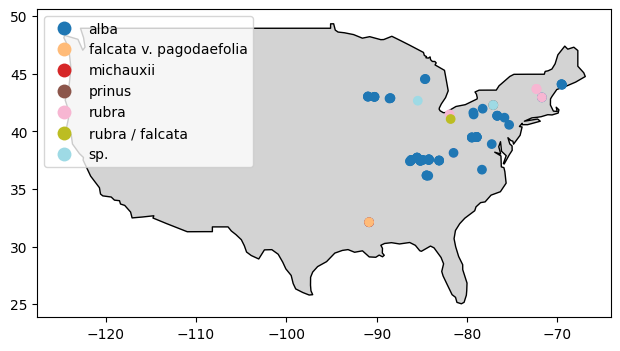

In [59]:
# to see what species we are working with 

fig, ax = plt.subplots(figsize=(8, 4))
usa.plot(ax = ax, color = 'lightgray', edgecolor = 'black')
tree.plot(column='Species', cmap= 'tab20',  legend=True, ax=ax);


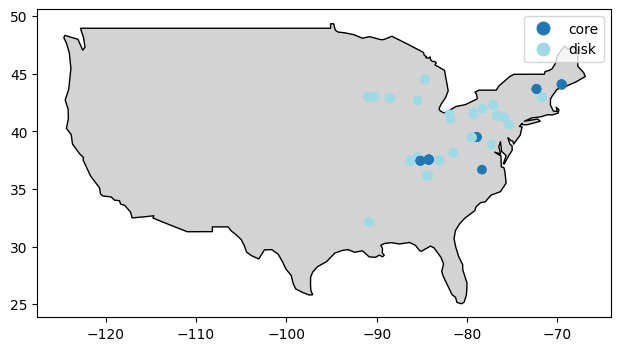

In [60]:
# to see what types of samples we are working with 

fig, ax = plt.subplots(figsize=(8, 4))
usa.plot(ax = ax, color = 'lightgray', edgecolor = 'black')
tree.plot(column='Type of sample', cmap= 'tab20',  legend=True, ax=ax);


#### now we hot encode ?? Maybe not needed just yet actually 
- Type of sample
- Species 


In [61]:
tree_encoded = pd.get_dummies(
    tree,
    columns=['Species', 'Type of sample'],
    drop_first=False  # keep all categories
)


In [62]:
#list(tree_encoded.columns)

# Oxygen model furrst 

## Just Latitude and Longitude

In [63]:
features = ['Latitude']
target = 'd18O'
region= 'RegionCluster'

# define model inputs 
df_model = tree[features + [target]+ [region]].dropna()
X = df_model[features].values
y = df_model[target].values
regional_groups = df_model['RegionCluster'].values

# make spatial validation groups 
group_kfold = GroupKFold(n_splits=6) 
regional_kfold = group_kfold.split(X, y, regional_groups )  
train_indices, test_indices = [list(traintest) for traintest in zip(*regional_kfold)]
regional_groups_cv = [*zip(train_indices,test_indices)]

# model + CV predictions
model = LinearRegression()
predictions = cross_val_predict(model, X, y, cv=regional_groups_cv)
model.fit(X, y)

# R2 and RMSE calculations and metrics
rmse = np.sqrt(mean_squared_error(y, predictions))
r2 = r2_score(y, predictions)
print(f"Cross-Validated RMSE: {rmse:.2f}")
print(f"Cross-Validated R²: {r2:.2f}")

# AIC and BIC calculations
n = len(y)  
k = X.shape[1]  

mse = mean_squared_error(y, predictions)
log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - (1 / (2 * mse)) * np.sum((y - predictions) ** 2)

aic = 2 * k - 2 * log_likelihood
bic = np.log(n) * k - 2 * log_likelihood

print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

#add prediction to dataframe 
#tree[f'{target}_pred_with_{features}']= predictions

Cross-Validated RMSE: 0.59
Cross-Validated R²: 0.53
AIC: 141.11
BIC: 143.46


In [64]:
features = ['Longitude', 'Latitude']
target = 'd18O'
region= 'RegionCluster'

# define model inputs 
df_model = tree[features + [target]+ [region]].dropna()
X = df_model[features].values
y = df_model[target].values
regional_groups = df_model['RegionCluster'].values

# make spatial validation groups 
group_kfold = GroupKFold(n_splits=6) 
regional_kfold = group_kfold.split(X, y, regional_groups )  
train_indices, test_indices = [list(traintest) for traintest in zip(*regional_kfold)]
regional_groups_cv = [*zip(train_indices,test_indices)]

# model + CV predictions
model = LinearRegression()
predictions = cross_val_predict(model, X, y, cv=regional_groups_cv)
model.fit(X, y)

# R2 and RMSE calculations and metrics
rmse = np.sqrt(mean_squared_error(y, predictions))
r2 = r2_score(y, predictions)
print(f"Cross-Validated RMSE: {rmse:.2f}")
print(f"Cross-Validated R²: {r2:.2f}")

# AIC and BIC calculations
n = len(y)  
k = X.shape[1]  

mse = mean_squared_error(y, predictions)
log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - (1 / (2 * mse)) * np.sum((y - predictions) ** 2)

aic = 2 * k - 2 * log_likelihood
bic = np.log(n) * k - 2 * log_likelihood

print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

#add prediction to dataframe 
#tree[f'{target}_pred_with_{features}']= predictions

Cross-Validated RMSE: 0.70
Cross-Validated R²: 0.34
AIC: 170.00
BIC: 174.71


In [65]:
#list(tree.columns)

## Iterate through to find best models with 3 and 4 features 

In [66]:
# --- Setup ---
candidate_features = [
    'Latitude',
 'Longitude',
    'aspect',
 'elevation_dem',
 'slope',
 'dist_to_ocean_m',
 'dist_to_coalplant_m',
 'HAND',
    'NDMI_yr_L8',
 'NDSI_yr_L8',
 'NDVI_yr_L8',
 'NDWI_yr_L8',
 'SAVI_yr_L8',
 'SR_B1_yr_L8',
 'SR_B2_yr_L8',
 'SR_B3_yr_L8',
 'SR_B4_yr_L8',
 'SR_B5_yr_L8',
 'SR_B6_yr_L8',
 'SR_B7_yr_L8',
# 'ST_ATRAN_yr_L8',
 'ST_B10_yr_L8',
 #'ST_DRAD_yr_L8',
 #'ST_EMIS_yr_L8',
 #'ST_TRAD_yr_L8',
 #'ST_URAD_yr_L8',
 'TC_Brightness_yr_L8',
 'TC_Vegetation_yr_L8',
 'TC_Wetness_yr_L8',
#'Fpar_500m_yr_MODIS',
 #'Lai_500m_yr_MODIS',
    'annual_precipitation_PRISIM',
    'annual_maximum_temperature_PRISIM',
    'annual_mean_temperature_PRISIM',
   'annual_minimum_temperature_PRISIM',
  #  'annual_precipitation_nClimGrid',
   # 'annual_tmax_nClimGrid',
  #   'annual_tavg_nClimGrid',
  #   'annual_tmin_nClimGrid',

]

target = 'd18O'
region = 'RegionCluster'

# Subset model data
df_model = tree[candidate_features + [target] + [region]].dropna()
y = df_model[target].values
regional_groups = df_model[region].values

# Spatial CV groups
group_kfold = GroupKFold(n_splits=6)
regional_groups_cv = list(group_kfold.split(df_model[candidate_features], y, regional_groups))

# --- Forward selection up to 3 features ---
oxygen_results = []
for k in range(1, 5):  # test 1, 2, 3 feature models
    for subset in itertools.combinations(candidate_features, k):
        X = df_model[list(subset)].values
        model = LinearRegression()

        predictions = cross_val_predict(model, X, y, cv=regional_groups_cv)
        rmse = np.sqrt(mean_squared_error(y, predictions))
        r2 = r2_score(y, predictions)

        # AIC / BIC
        n = len(y)
        k_params = X.shape[1]
        mse = mean_squared_error(y, predictions)
        log_likelihood = -n/2 * np.log(2*np.pi*mse) - (1/(2*mse)) * np.sum((y - predictions)**2)
        aic = 2 * k_params - 2 * log_likelihood
        bic = np.log(n) * k_params - 2 * log_likelihood

        oxygen_results.append({
            'features': subset,
            'rmse': rmse,
            'r2': r2,
            'aic': aic,
            'bic': bic
        })

oxygen_results_df = pd.DataFrame(oxygen_results).sort_values(by="rmse")
oxygen_results_df.head(3) 


,features,rmse,r2,aic,bic
20240,"(NDMI_yr_L8, ST_B10_yr_L8, annual_precipitatio...",0.508225,0.652081,123.768847,133.195682
2996,"(NDVI_yr_L8, annual_precipitation_PRISIM, annu...",0.509551,0.650265,122.175130,129.245257
21736,"(NDVI_yr_L8, ST_B10_yr_L8, annual_precipitatio...",0.510735,0.648637,124.537214,133.964050


In [67]:
oxygen_results_df.head(3)

,features,rmse,r2,aic,bic
20240,"(NDMI_yr_L8, ST_B10_yr_L8, annual_precipitatio...",0.508225,0.652081,123.768847,133.195682
2996,"(NDVI_yr_L8, annual_precipitation_PRISIM, annu...",0.509551,0.650265,122.175130,129.245257
21736,"(NDVI_yr_L8, ST_B10_yr_L8, annual_precipitatio...",0.510735,0.648637,124.537214,133.964050


In [68]:
best_4_oxygen = oxygen_results_df[oxygen_results_df["features"].apply(len) == 4].sort_values("r2").head(1)

list(best_4_oxygen.features)

[('elevation_dem', 'dist_to_ocean_m', 'SR_B5_yr_L8', 'TC_Brightness_yr_L8')]

In [69]:

best_3_oxygen = oxygen_results_df[oxygen_results_df["features"].apply(len) == 3].sort_values("r2").head(1)

list(best_3_oxygen.features)

[('elevation_dem', 'dist_to_ocean_m', 'NDVI_yr_L8')]

In [70]:
features = [
    
  'NDVI_yr_L8',
  #'TC_Vegetation_yr_L8',
 # 'SR_B6_yr_L8',
  'annual_precipitation_PRISIM',
  'annual_mean_temperature_PRISIM'
 ]
target = 'd18O'
region= 'RegionCluster'

# define model inputs 
df_model = tree[features + [target]+ [region]].dropna()
X = df_model[features].values
y = df_model[target].values
regional_groups = df_model['RegionCluster'].values

# make spatial validation groups 
group_kfold = GroupKFold(n_splits=6) 
regional_kfold = group_kfold.split(X, y, regional_groups )  
train_indices, test_indices = [list(traintest) for traintest in zip(*regional_kfold)]
regional_groups_cv = [*zip(train_indices,test_indices)]

# model + CV predictions
model = LinearRegression()
predictions = cross_val_predict(model, X, y, cv=regional_groups_cv)
model.fit(X, y)

# R2 and RMSE calculations and metrics
rmse = np.sqrt(mean_squared_error(y, predictions))
r2 = r2_score(y, predictions)
print(f"Cross-Validated RMSE: {rmse:.2f}")
print(f"Cross-Validated R²: {r2:.2f}")

# AIC and BIC calculations
n = len(y)  
k = X.shape[1]  

mse = mean_squared_error(y, predictions)
log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - (1 / (2 * mse)) * np.sum((y - predictions) ** 2)

aic = 2 * k - 2 * log_likelihood
bic = np.log(n) * k - 2 * log_likelihood

print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

#add prediction to dataframe 
tree[f'{target}_pred_with_{features}'] = np.nan
tree.loc[df_model.index, f'{target}_pred_with_{features}'] = predictions

Cross-Validated RMSE: 0.52
Cross-Validated R²: 0.64
AIC: 123.96
BIC: 131.03


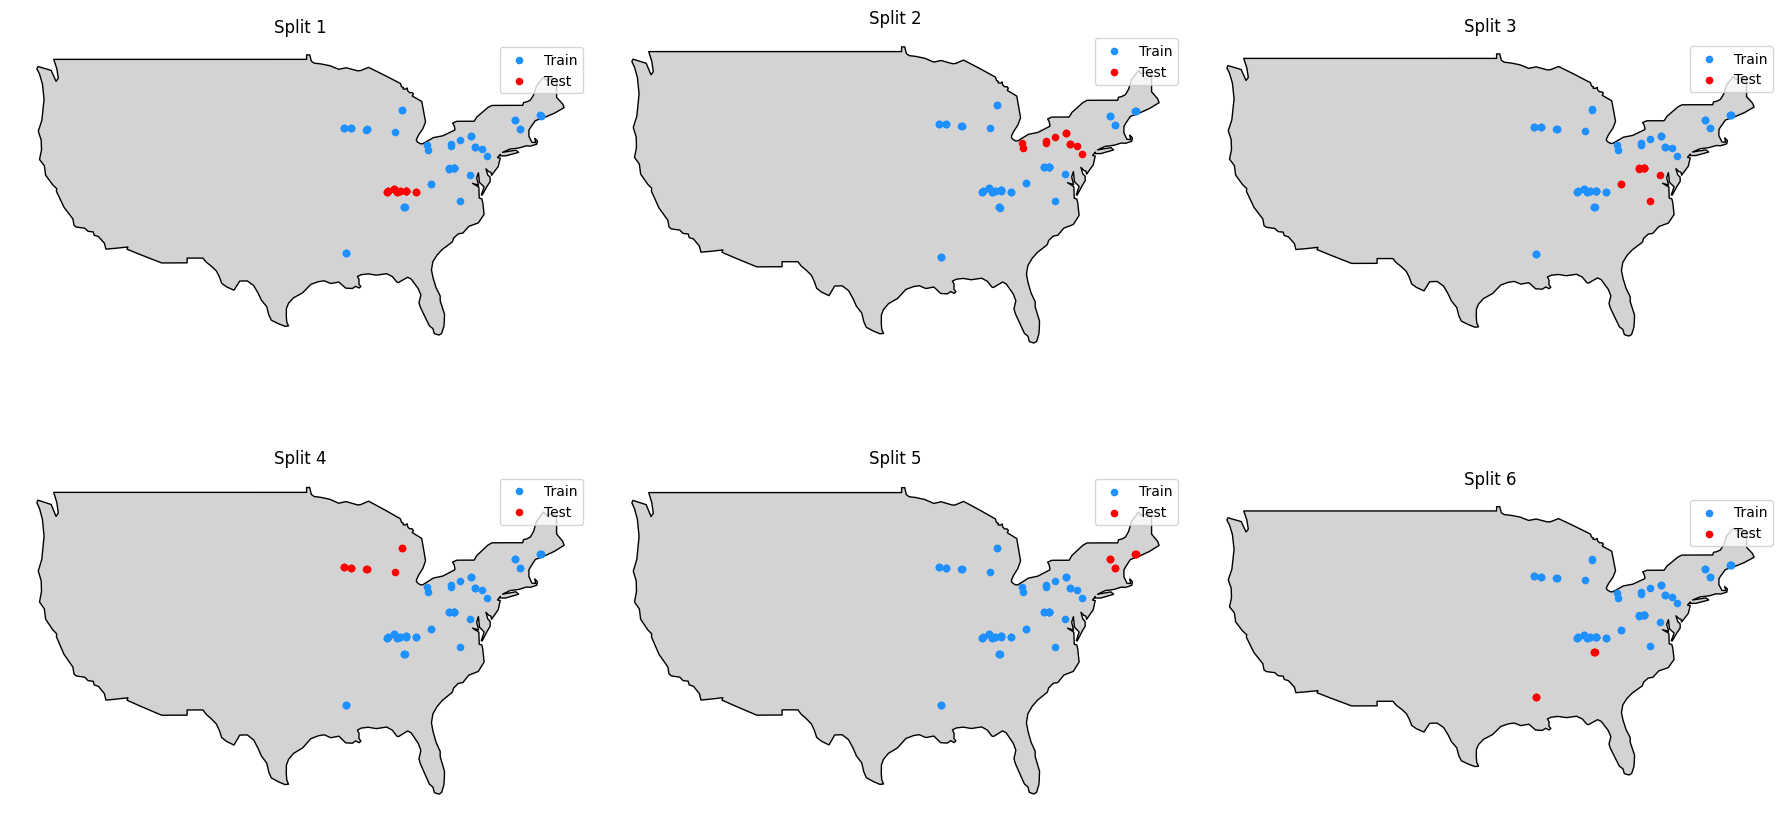

In [71]:
#create plot of the testing/ training sites 

#make same as the model just used 
tree_model = tree.loc[df_model.index]

#make the plots 
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  

axes = axes.flatten()

for i, (train_idx, test_idx) in enumerate(regional_groups_cv):
    
    train_data = tree_model.iloc[train_idx]
    test_data = tree_model.iloc[test_idx]
    
    ax = axes[i]
    usa.plot(ax=ax, color='lightgray', edgecolor='black')  
    train_data.plot(ax=ax, color='dodgerblue', markersize=20, label='Train')
    test_data.plot(ax=ax, color='red', markersize=20, label='Test')

    ax.legend()
    ax.set_title(f'Split {i+1}')
    ax.set_axis_off()


plt.tight_layout()
plt.show()


In [72]:
tree.head()

,tree_id,Region,Latitude,Longitude,geometry,Species,Date collected,Type of sample,Height of sample,Diameter of tree at sample location (inches),...,6_tmin_nClimGrid,7_tmin_nClimGrid,8_tmin_nClimGrid,9_tmin_nClimGrid,10_tmin_nClimGrid,11_tmin_nClimGrid,12_tmin_nClimGrid,annual_tmin_nClimGrid,RegionCluster,"d18O_pred_with_['NDVI_yr_L8', 'annual_precipitation_PRISIM', 'annual_mean_temperature_PRISIM']"
0,0,Ohio,41.486318,-81.934554,POINT (-81.93455 41.48632),rubra,01/07/17,disk,NaN,27.5,...,16.492676,19.165266,18.392643,14.586589,8.672624,2.884961,-1.714681,6.962891,New Yorkish,24.093053
1,1,Michigan,42.667700,-85.449200,POINT (-85.4492 42.6677),sp.,05/03/19,disk,NaN,9.0,...,13.523373,15.648698,14.951367,10.567318,4.909961,-0.368978,-4.949381,3.741542,Midwest,23.674446
2,2,Pennsylvania,40.573010,-75.339340,POINT (-75.33934 40.57301),alba,16/01/19,disk,NaN,9.0,...,14.309050,17.111622,16.050976,12.029753,5.415690,0.469401,-3.621094,5.051194,New Yorkish,24.388284
3,3,Pennsylvania,41.195420,-75.856400,POINT (-75.8564 41.19542),alba,19/01/19,disk,NaN,8.0,...,11.748763,14.286361,13.614323,9.920410,3.801302,-1.403646,-5.992969,2.602510,New Yorkish,24.052560
4,4,Michigan,44.560850,-84.608510,POINT (-84.60851 44.56085),alba,20/03/19,disk,1.0,14.0,...,10.602083,12.727995,12.056608,7.842708,2.612760,-2.448600,-7.438184,0.787554,Midwest,23.319817


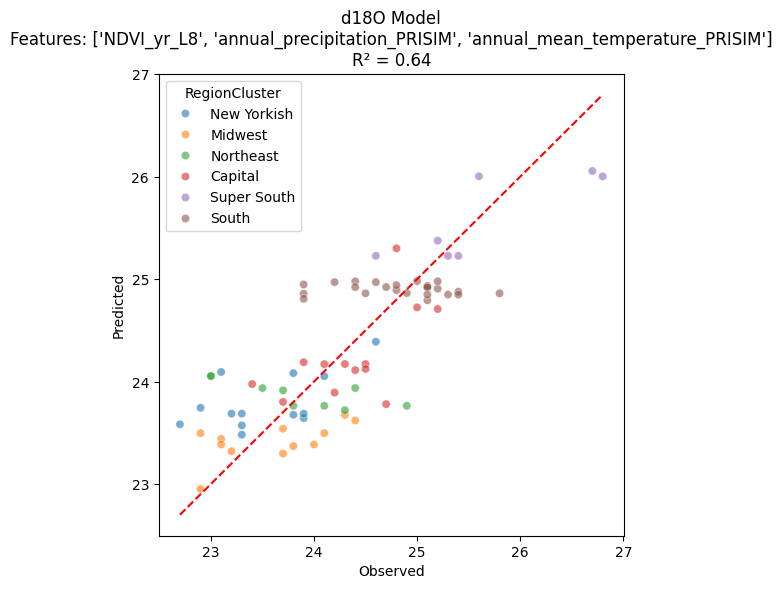

In [73]:
#plot pred vs obs

plt.figure(figsize=(6,6))
sns.scatterplot(
    data=tree,
    x='d18O',
    y="d18O_pred_with_['NDVI_yr_L8', 'annual_precipitation_PRISIM', 'annual_mean_temperature_PRISIM']",
    hue='RegionCluster',   
    palette='tab10',     
    alpha=0.6
)

# 1:1 line
plt.plot([tree['d18O'].min(), tree['d18O'].max()],
         [tree['d18O'].min(), tree['d18O'].max()], 'r--')

plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title(f"{target} Model\nFeatures: {features}\nR² = {r2:.2f}")
plt.show()


## Hydrogen nexttttt

### just latitude and longitude 

In [75]:
features = ['Latitude']
target = 'd2H'
region= 'RegionCluster'

# define model inputs 
df_model = tree[features + [target]+ [region]].dropna()
X = df_model[features].values
y = df_model[target].values
regional_groups = df_model['RegionCluster'].values

# make spatial validation groups 
group_kfold = GroupKFold(n_splits=6) 
regional_kfold = group_kfold.split(X, y, regional_groups )  
train_indices, test_indices = [list(traintest) for traintest in zip(*regional_kfold)]
regional_groups_cv = [*zip(train_indices,test_indices)]

# model + CV predictions
model = LinearRegression()
predictions = cross_val_predict(model, X, y, cv=regional_groups_cv)
model.fit(X, y)

# R2 and RMSE calculations and metrics
rmse = np.sqrt(mean_squared_error(y, predictions))
r2 = r2_score(y, predictions)
print(f"Cross-Validated RMSE: {rmse:.2f}")
print(f"Cross-Validated R²: {r2:.2f}")

# AIC and BIC calculations
n = len(y)  
k = X.shape[1]  

mse = mean_squared_error(y, predictions)
log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - (1 / (2 * mse)) * np.sum((y - predictions) ** 2)

aic = 2 * k - 2 * log_likelihood
bic = np.log(n) * k - 2 * log_likelihood

print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

#add prediction to dataframe 
#tree[f'{target}_pred_with_{features}']= predictions

Cross-Validated RMSE: 5.78
Cross-Validated R²: 0.51
AIC: 497.13
BIC: 499.49


In [76]:
features = ['Longitude','Latitude']
target = 'd2H'
region= 'RegionCluster'

# define model inputs 
df_model = tree[features + [target]+ [region]].dropna()
X = df_model[features].values
y = df_model[target].values
regional_groups = df_model['RegionCluster'].values

# make spatial validation groups 
group_kfold = GroupKFold(n_splits=6) 
regional_kfold = group_kfold.split(X, y, regional_groups )  
train_indices, test_indices = [list(traintest) for traintest in zip(*regional_kfold)]
regional_groups_cv = [*zip(train_indices,test_indices)]

# model + CV predictions
model = LinearRegression()
predictions = cross_val_predict(model, X, y, cv=regional_groups_cv)
model.fit(X, y)

# R2 and RMSE calculations and metrics
rmse = np.sqrt(mean_squared_error(y, predictions))
r2 = r2_score(y, predictions)
print(f"Cross-Validated RMSE: {rmse:.2f}")
print(f"Cross-Validated R²: {r2:.2f}")

# AIC and BIC calculations
n = len(y)  
k = X.shape[1]  

mse = mean_squared_error(y, predictions)
log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - (1 / (2 * mse)) * np.sum((y - predictions) ** 2)

aic = 2 * k - 2 * log_likelihood
bic = np.log(n) * k - 2 * log_likelihood

print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

#add prediction to dataframe 
#tree[f'{target}_pred_with_{features}']= predictions

Cross-Validated RMSE: 6.06
Cross-Validated R²: 0.46
AIC: 506.29
BIC: 511.01


In [77]:
# --- Setup ---
candidate_features = [
 #   'Latitude',
 #'Longitude',
    'aspect',
 'elevation_dem',
 'slope',
 'dist_to_ocean_m',
 'dist_to_coalplant_m',
 'HAND',
    'NDMI_yr_L8',
 'NDSI_yr_L8',
 'NDVI_yr_L8',
 'NDWI_yr_L8',
 'SAVI_yr_L8',
 'SR_B1_yr_L8',
 'SR_B2_yr_L8',
 'SR_B3_yr_L8',
 'SR_B4_yr_L8',
 'SR_B5_yr_L8',
 'SR_B6_yr_L8',
 'SR_B7_yr_L8',
# 'ST_ATRAN_yr_L8',
 'ST_B10_yr_L8',
 #'ST_DRAD_yr_L8',
 #'ST_EMIS_yr_L8',
 #'ST_TRAD_yr_L8',
 #'ST_URAD_yr_L8',
 'TC_Brightness_yr_L8',
 'TC_Vegetation_yr_L8',
 'TC_Wetness_yr_L8',
#'Fpar_500m_yr_MODIS',
 #'Lai_500m_yr_MODIS',
    'annual_precipitation_PRISIM',
    'annual_maximum_temperature_PRISIM',
    'annual_mean_temperature_PRISIM',
   'annual_minimum_temperature_PRISIM',
  #  'annual_precipitation_nClimGrid',
   # 'annual_tmax_nClimGrid',
  #   'annual_tavg_nClimGrid',
  #   'annual_tmin_nClimGrid',

]

target = 'd2H'
region = 'RegionCluster'

# Subset model data
df_model = tree[candidate_features + [target] + [region]].dropna()
y = df_model[target].values
regional_groups = df_model[region].values

# Spatial CV groups
group_kfold = GroupKFold(n_splits=6)
regional_groups_cv = list(group_kfold.split(df_model[candidate_features], y, regional_groups))

# --- Forward selection up to 4 features ---
hydrogen_results = []
for k in range(1, 5):  # test 1, 2, 3, 4 feature models
    for subset in itertools.combinations(candidate_features, k):
        X = df_model[list(subset)].values
        model = LinearRegression()

        predictions = cross_val_predict(model, X, y, cv=regional_groups_cv)
        rmse = np.sqrt(mean_squared_error(y, predictions))
        r2 = r2_score(y, predictions)

        # AIC / BIC
        n = len(y)
        k_params = X.shape[1]
        mse = mean_squared_error(y, predictions)
        log_likelihood = -n/2 * np.log(2*np.pi*mse) - (1/(2*mse)) * np.sum((y - predictions)**2)
        aic = 2 * k_params - 2 * log_likelihood
        bic = np.log(n) * k_params - 2 * log_likelihood

        hydrogen_results.append({
            'features': subset,
            'rmse': rmse,
            'r2': r2,
            'aic': aic,
            'bic': bic
        })

hydrogen_results_df = pd.DataFrame(hydrogen_results).sort_values(by="rmse")
hydrogen_results_df.head(3) 


,features,rmse,r2,aic,bic
9900,"(dist_to_ocean_m, NDVI_yr_L8, annual_precipita...",5.076619,0.621524,482.799117,492.225952
9901,"(dist_to_ocean_m, NDVI_yr_L8, annual_precipita...",5.090197,0.619497,483.215794,492.642629
10020,"(dist_to_ocean_m, NDWI_yr_L8, annual_precipita...",5.105005,0.617280,483.668954,493.095790


In [78]:
hydrogen_results_df.head(10) 

,features,rmse,r2,aic,bic
9900,"(dist_to_ocean_m, NDVI_yr_L8, annual_precipita...",5.076619,0.621524,482.799117,492.225952
9901,"(dist_to_ocean_m, NDVI_yr_L8, annual_precipita...",5.090197,0.619497,483.215794,492.642629
10020,"(dist_to_ocean_m, NDWI_yr_L8, annual_precipita...",5.105005,0.617280,483.668954,493.095790
10021,"(dist_to_ocean_m, NDWI_yr_L8, annual_precipita...",5.124387,0.614368,484.260113,493.686949
9902,"(dist_to_ocean_m, NDVI_yr_L8, annual_precipita...",5.159061,0.609132,485.312141,494.738976
9031,"(slope, TC_Vegetation_yr_L8, annual_precipitat...",5.184234,0.605308,486.071452,495.498288
9030,"(slope, TC_Vegetation_yr_L8, annual_precipitat...",5.185913,0.605052,486.121984,495.548819
10415,"(dist_to_ocean_m, SR_B4_yr_L8, annual_precipit...",5.224811,0.599106,487.287712,496.714547
10216,"(dist_to_ocean_m, SR_B1_yr_L8, annual_precipit...",5.226822,0.598797,487.347753,496.774588
10416,"(dist_to_ocean_m, SR_B4_yr_L8, annual_precipit...",5.228848,0.598486,487.408212,496.835047


In [79]:
hydrogen_best_4 = hydrogen_results_df[hydrogen_results_df["features"].apply(len) == 4].sort_values("rmse").head(1)

list(hydrogen_best_4.features)
hydrogen_best_4 

,features,rmse,r2,aic,bic
9900,"(dist_to_ocean_m, NDVI_yr_L8, annual_precipita...",5.076619,0.621524,482.799117,492.225952


In [80]:
hydrogen_best_3 = hydrogen_results_df[hydrogen_results_df["features"].apply(len) == 3].sort_values("rmse").head(1)

list(hydrogen_best_3.features)

hydrogen_best_3

,features,rmse,r2,aic,bic
2265,"(NDVI_yr_L8, annual_precipitation_PRISIM, annu...",5.415636,0.569287,490.883708,497.953834


In [81]:
#test same as oxygen 

features = [
    
'dist_to_ocean_m',
  'NDVI_yr_L8',
  'annual_precipitation_PRISIM',
  'annual_maximum_temperature_PRISIM'
 ]
target = 'd2H'
region= 'RegionCluster'

# define model inputs 
df_model = tree[features + [target]+ [region]].dropna()
X = df_model[features].values
y = df_model[target].values
regional_groups = df_model['RegionCluster'].values

# make spatial validation groups 
group_kfold = GroupKFold(n_splits=6) 
regional_kfold = group_kfold.split(X, y, regional_groups )  
train_indices, test_indices = [list(traintest) for traintest in zip(*regional_kfold)]
regional_groups_cv = [*zip(train_indices,test_indices)]

# model + CV predictions
model = LinearRegression()
predictions = cross_val_predict(model, X, y, cv=regional_groups_cv)
model.fit(X, y)

# R2 and RMSE calculations and metrics
rmse = np.sqrt(mean_squared_error(y, predictions))
r2 = r2_score(y, predictions)
print(f"Cross-Validated RMSE: {rmse:.2f}")
print(f"Cross-Validated R²: {r2:.2f}")

# AIC and BIC calculations
n = len(y)  
k = X.shape[1]  

mse = mean_squared_error(y, predictions)
log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - (1 / (2 * mse)) * np.sum((y - predictions) ** 2)

aic = 2 * k - 2 * log_likelihood
bic = np.log(n) * k - 2 * log_likelihood

print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

#add prediction to dataframe 
#tree[f'{target}_pred_with_{features}'] = np.nan
#tree.loc[df_model.index, f'{target}_pred_with_{features}'] = predictions

Cross-Validated RMSE: 5.08
Cross-Validated R²: 0.62
AIC: 482.80
BIC: 492.23


In [82]:
features = [
    
 'Longitude', 'slope', 'NDMI_yr_L8', 'annual_precipitation_PRISIM'
 ]
target = 'd2H'
region= 'RegionCluster'

# define model inputs 
df_model = tree[features + [target]+ [region]].dropna()
X = df_model[features].values
y = df_model[target].values
regional_groups = df_model['RegionCluster'].values

# make spatial validation groups 
group_kfold = GroupKFold(n_splits=6) 
regional_kfold = group_kfold.split(X, y, regional_groups )  
train_indices, test_indices = [list(traintest) for traintest in zip(*regional_kfold)]
regional_groups_cv = [*zip(train_indices,test_indices)]

# model + CV predictions
model = LinearRegression()
predictions = cross_val_predict(model, X, y, cv=regional_groups_cv)
model.fit(X, y)

# R2 and RMSE calculations and metrics
rmse = np.sqrt(mean_squared_error(y, predictions))
r2 = r2_score(y, predictions)
print(f"Cross-Validated RMSE: {rmse:.2f}")
print(f"Cross-Validated R²: {r2:.2f}")

# AIC and BIC calculations
n = len(y)  
k = X.shape[1]  

mse = mean_squared_error(y, predictions)
log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - (1 / (2 * mse)) * np.sum((y - predictions) ** 2)

aic = 2 * k - 2 * log_likelihood
bic = np.log(n) * k - 2 * log_likelihood

print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

#add prediction to dataframe 
tree[f'{target}_pred_with_{features}'] = np.nan
tree.loc[df_model.index, f'{target}_pred_with_{features}'] = predictions

Cross-Validated RMSE: 4.85
Cross-Validated R²: 0.65
AIC: 475.77
BIC: 485.20


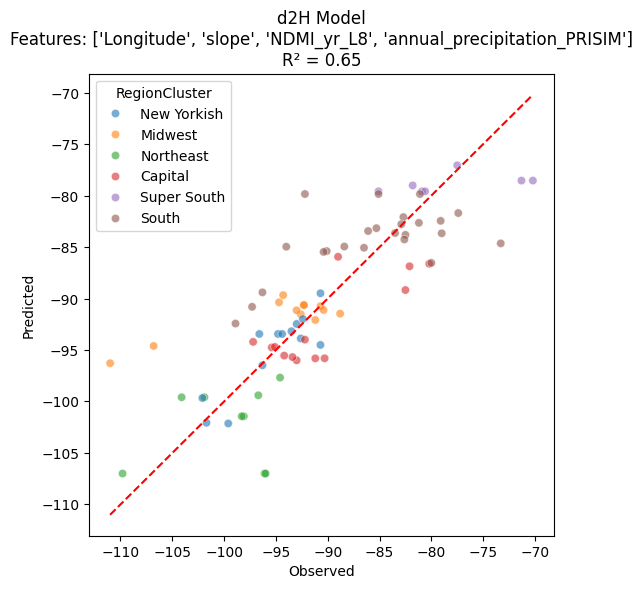

In [84]:
#plot pred vs obs

plt.figure(figsize=(6,6))
sns.scatterplot(
    data=tree,
    x='d2H',
    y="d2H_pred_with_['Longitude', 'slope', 'NDMI_yr_L8', 'annual_precipitation_PRISIM']",
    hue='RegionCluster',   
    palette='tab10',     
    alpha=0.6
)

# 1:1 line
plt.plot([tree['d2H'].min(), tree['d2H'].max()],
         [tree['d2H'].min(), tree['d2H'].max()], 'r--')

plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title(f"{target} Model\nFeatures: {features}\nR² = {r2:.2f}")
plt.show()


## Now carbonnnnn

In [85]:
features = [#'Latitude',
            'Longitude']
target = 'd13C'
region= 'RegionCluster'

# define model inputs 
df_model = tree[features + [target]+ [region]].dropna()
X = df_model[features].values
y = df_model[target].values
regional_groups = df_model['RegionCluster'].values

# make spatial validation groups 
group_kfold = GroupKFold(n_splits=6) 
regional_kfold = group_kfold.split(X, y, regional_groups )  
train_indices, test_indices = [list(traintest) for traintest in zip(*regional_kfold)]
regional_groups_cv = [*zip(train_indices,test_indices)]

# model + CV predictions
model = LinearRegression()
predictions = cross_val_predict(model, X, y, cv=regional_groups_cv)
model.fit(X, y)

# R2 and RMSE calculations and metrics
rmse = np.sqrt(mean_squared_error(y, predictions))
r2 = r2_score(y, predictions)
print(f"Cross-Validated RMSE: {rmse:.2f}")
print(f"Cross-Validated R²: {r2:.2f}")

# AIC and BIC calculations
n = len(y)  
k = X.shape[1]  

mse = mean_squared_error(y, predictions)
log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - (1 / (2 * mse)) * np.sum((y - predictions) ** 2)

aic = 2 * k - 2 * log_likelihood
bic = np.log(n) * k - 2 * log_likelihood

print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

#add prediction to dataframe 
#tree[f'{target}_pred_with_{features}']= predictions

Cross-Validated RMSE: 0.91
Cross-Validated R²: 0.05
AIC: 209.06
BIC: 211.42


In [86]:
# --- Setup ---
candidate_features = [
  #  'Latitude',
 #'Longitude',
    'aspect',
 'elevation_dem',
 'slope',
 'dist_to_ocean_m',
 'dist_to_coalplant_m',
 'HAND',
    'NDMI_yr_L8',
 'NDSI_yr_L8',
 'NDVI_yr_L8',
 'NDWI_yr_L8',
 'SAVI_yr_L8',
 'SR_B1_yr_L8',
 'SR_B2_yr_L8',
 'SR_B3_yr_L8',
 'SR_B4_yr_L8',
 'SR_B5_yr_L8',
 'SR_B6_yr_L8',
 'SR_B7_yr_L8',
# 'ST_ATRAN_yr_L8',
 'ST_B10_yr_L8',
 #'ST_DRAD_yr_L8',
 #'ST_EMIS_yr_L8',
 #'ST_TRAD_yr_L8',
 #'ST_URAD_yr_L8',
 'TC_Brightness_yr_L8',
 'TC_Vegetation_yr_L8',
 'TC_Wetness_yr_L8',
#'Fpar_500m_yr_MODIS',
 #'Lai_500m_yr_MODIS',
    'annual_precipitation_PRISIM',
    'annual_maximum_temperature_PRISIM',
    'annual_mean_temperature_PRISIM',
   'annual_minimum_temperature_PRISIM',
  #  'annual_precipitation_nClimGrid',
   # 'annual_tmax_nClimGrid',
  #   'annual_tavg_nClimGrid',
  #   'annual_tmin_nClimGrid',

]

target = 'd13C'
region = 'RegionCluster'

# Subset model data
df_model = tree[candidate_features + [target] + [region]].dropna()
y = df_model[target].values
regional_groups = df_model[region].values

# Spatial CV groups
group_kfold = GroupKFold(n_splits=6)
regional_groups_cv = list(group_kfold.split(df_model[candidate_features], y, regional_groups))

# --- Forward selection up to 4 features ---
carbon_results = []
for k in range(1, 5):  # test 1, 2, 3, 4 feature models
    for subset in itertools.combinations(candidate_features, k):
        X = df_model[list(subset)].values
        model = LinearRegression()

        predictions = cross_val_predict(model, X, y, cv=regional_groups_cv)
        rmse = np.sqrt(mean_squared_error(y, predictions))
        r2 = r2_score(y, predictions)

        # AIC / BIC
        n = len(y)
        k_params = X.shape[1]
        mse = mean_squared_error(y, predictions)
        log_likelihood = -n/2 * np.log(2*np.pi*mse) - (1/(2*mse)) * np.sum((y - predictions)**2)
        aic = 2 * k_params - 2 * log_likelihood
        bic = np.log(n) * k_params - 2 * log_likelihood

        carbon_results.append({
            'features': subset,
            'rmse': rmse,
            'r2': r2,
            'aic': aic,
            'bic': bic
        })

carbon_results_df = pd.DataFrame(carbon_results).sort_values(by="rmse")


In [87]:
carbon_results_df.head(5) 

,features,rmse,r2,aic,bic
9249,"(dist_to_ocean_m, dist_to_coalplant_m, TC_Wetn...",0.816077,0.241458,197.648002,207.074837
9189,"(dist_to_ocean_m, dist_to_coalplant_m, SR_B3_y...",0.816477,0.240715,197.724364,207.151199
9177,"(dist_to_ocean_m, dist_to_coalplant_m, SR_B2_y...",0.823925,0.226800,199.140934,208.567769
9248,"(dist_to_ocean_m, dist_to_coalplant_m, TC_Wetn...",0.825422,0.223988,199.424098,208.850933
9164,"(dist_to_ocean_m, dist_to_coalplant_m, SR_B1_y...",0.826096,0.222719,199.551505,208.978340


In [88]:
carbon_best_4 = carbon_results_df[carbon_results_df["features"].apply(len) == 4].sort_values("rmse").head(1)

carbon_best_4
list(carbon_best_4.features)

[('dist_to_ocean_m',
  'dist_to_coalplant_m',
  'TC_Wetness_yr_L8',
  'annual_minimum_temperature_PRISIM')]

In [89]:
carbon_best_3 = carbon_results_df[carbon_results_df["features"].apply(len) == 3].sort_values("rmse").head(1)

list(carbon_best_3.features)
carbon_best_3

,features,rmse,r2,aic,bic
1200,"(dist_to_ocean_m, dist_to_coalplant_m, annual_...",0.836655,0.202722,199.532851,206.602978


In [90]:
features = [

    'dist_to_ocean_m',
  'dist_to_coalplant_m',
  'TC_Wetness_yr_L8',
  'annual_minimum_temperature_PRISIM'
           
           ]
target = 'd13C'
region= 'RegionCluster'

# define model inputs 
df_model = tree[features + [target]+ [region]].dropna()
X = df_model[features].values
y = df_model[target].values
regional_groups = df_model['RegionCluster'].values

# make spatial validation groups 
group_kfold = GroupKFold(n_splits=6) 
regional_kfold = group_kfold.split(X, y, regional_groups )  
train_indices, test_indices = [list(traintest) for traintest in zip(*regional_kfold)]
regional_groups_cv = [*zip(train_indices,test_indices)]

# model + CV predictions
model = LinearRegression()
predictions = cross_val_predict(model, X, y, cv=regional_groups_cv)
model.fit(X, y)

# R2 and RMSE calculations and metrics
rmse = np.sqrt(mean_squared_error(y, predictions))
r2 = r2_score(y, predictions)
print(f"Cross-Validated RMSE: {rmse:.2f}")
print(f"Cross-Validated R²: {r2:.2f}")

# AIC and BIC calculations
n = len(y)  
k = X.shape[1]  

mse = mean_squared_error(y, predictions)
log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - (1 / (2 * mse)) * np.sum((y - predictions) ** 2)

aic = 2 * k - 2 * log_likelihood
bic = np.log(n) * k - 2 * log_likelihood

print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

#add prediction to dataframe 
#tree[f'{target}_pred_with_{features}']= predictions

Cross-Validated RMSE: 0.82
Cross-Validated R²: 0.24
AIC: 197.65
BIC: 207.07


In [94]:
features = ['Longitude', 'dist_to_coalplant_m', 'annual_precipitation_PRISIM'
           
           ]
target = 'd13C'
region= 'RegionCluster'

# define model inputs 
df_model = tree[features + [target]+ [region]].dropna()
X = df_model[features].values
y = df_model[target].values
regional_groups = df_model['RegionCluster'].values

# make spatial validation groups 
group_kfold = GroupKFold(n_splits=6) 
regional_kfold = group_kfold.split(X, y, regional_groups )  
train_indices, test_indices = [list(traintest) for traintest in zip(*regional_kfold)]
regional_groups_cv = [*zip(train_indices,test_indices)]

# model + CV predictions
model = LinearRegression()
predictions = cross_val_predict(model, X, y, cv=regional_groups_cv)
model.fit(X, y)

# R2 and RMSE calculations and metrics
rmse = np.sqrt(mean_squared_error(y, predictions))
r2 = r2_score(y, predictions)
print(f"Cross-Validated RMSE: {rmse:.2f}")
print(f"Cross-Validated R²: {r2:.2f}")

# AIC and BIC calculations
n = len(y)  
k = X.shape[1]  

mse = mean_squared_error(y, predictions)
log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - (1 / (2 * mse)) * np.sum((y - predictions) ** 2)

aic = 2 * k - 2 * log_likelihood
bic = np.log(n) * k - 2 * log_likelihood

print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

#add prediction to dataframe 
tree[f'{target}_pred_with_{features}']= predictions

Cross-Validated RMSE: 0.78
Cross-Validated R²: 0.31
AIC: 187.90
BIC: 194.97


In [95]:
tree.head()

,tree_id,Region,Latitude,Longitude,geometry,Species,Date collected,Type of sample,Height of sample,Diameter of tree at sample location (inches),...,9_tmin_nClimGrid,10_tmin_nClimGrid,11_tmin_nClimGrid,12_tmin_nClimGrid,annual_tmin_nClimGrid,RegionCluster,"d18O_pred_with_['NDVI_yr_L8', 'annual_precipitation_PRISIM', 'annual_mean_temperature_PRISIM']",residuals,"d2H_pred_with_['Longitude', 'slope', 'NDMI_yr_L8', 'annual_precipitation_PRISIM']","d13C_pred_with_['Longitude', 'dist_to_coalplant_m', 'annual_precipitation_PRISIM']"
0,0,Ohio,41.486318,-81.934554,POINT (-81.93455 41.48632),rubra,01/07/17,disk,NaN,27.5,...,14.586589,8.672624,2.884961,-1.714681,6.962891,New Yorkish,24.093053,-0.993053,-94.503832,-26.151842
1,1,Michigan,42.667700,-85.449200,POINT (-85.4492 42.6677),sp.,05/03/19,disk,NaN,9.0,...,10.567318,4.909961,-0.368978,-4.949381,3.741542,Midwest,23.674446,0.625554,-91.528486,-26.864713
2,2,Pennsylvania,40.573010,-75.339340,POINT (-75.33934 40.57301),alba,16/01/19,disk,NaN,9.0,...,12.029753,5.415690,0.469401,-3.621094,5.051194,New Yorkish,24.388284,0.211716,-92.466480,-26.067671
3,3,Pennsylvania,41.195420,-75.856400,POINT (-75.8564 41.19542),alba,19/01/19,disk,NaN,8.0,...,9.920410,3.801302,-1.403646,-5.992969,2.602510,New Yorkish,24.052560,0.047440,-93.876663,-26.228868
4,4,Michigan,44.560850,-84.608510,POINT (-84.60851 44.56085),alba,20/03/19,disk,1.0,14.0,...,7.842708,2.612760,-2.448600,-7.438184,0.787554,Midwest,23.319817,-0.119817,-96.281852,-27.032569


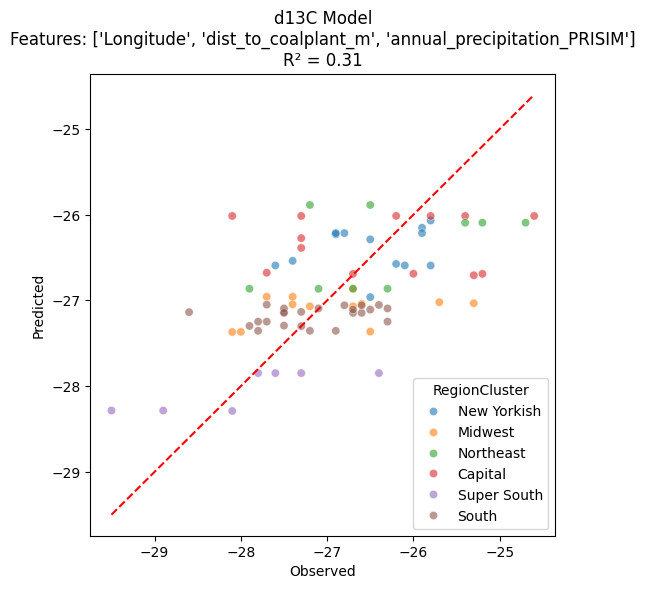

In [96]:
#plot pred vs obs

plt.figure(figsize=(6,6))
sns.scatterplot(
    data=tree,
    x='d13C',
    y="d13C_pred_with_['Longitude', 'dist_to_coalplant_m', 'annual_precipitation_PRISIM']",
    hue='RegionCluster',   
    palette='tab10',     
    alpha=0.6
)

# 1:1 line
plt.plot([tree['d13C'].min(), tree['d13C'].max()],
         [tree['d13C'].min(), tree['d13C'].max()], 'r--')

plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title(f"{target} Model\nFeatures: {features}\nR² = {r2:.2f}")
plt.show()


## Now just sulphur 

## Latitude and longitude
- absolutley horrific performance for both

In [97]:
list(tree.columns)

['tree_id',
 'Region',
 'Latitude',
 'Longitude',
 'geometry',
 'Species',
 'Date collected',
 'Type of sample',
 'Height of sample',
 'Diameter of tree at sample location (inches)',
 'd18O',
 'd2H',
 'd13C',
 'd34S',
 'aspect',
 'elevation_dem',
 'slope',
 'dist_to_ocean_m',
 'dist_to_coalplant_m',
 'HAND',
 'NDMI_Fall_L8',
 'NDMI_Spring_L8',
 'NDMI_Summer_L8',
 'NDMI_Winter_L8',
 'NDSI_Fall_L8',
 'NDSI_Spring_L8',
 'NDSI_Summer_L8',
 'NDSI_Winter_L8',
 'NDVI_Fall_L8',
 'NDVI_Spring_L8',
 'NDVI_Summer_L8',
 'NDVI_Winter_L8',
 'NDWI_Fall_L8',
 'NDWI_Spring_L8',
 'NDWI_Summer_L8',
 'NDWI_Winter_L8',
 'SAVI_Fall_L8',
 'SAVI_Spring_L8',
 'SAVI_Summer_L8',
 'SAVI_Winter_L8',
 'SR_B1_Fall_L8',
 'SR_B1_Spring_L8',
 'SR_B1_Summer_L8',
 'SR_B1_Winter_L8',
 'SR_B2_Fall_L8',
 'SR_B2_Spring_L8',
 'SR_B2_Summer_L8',
 'SR_B2_Winter_L8',
 'SR_B3_Fall_L8',
 'SR_B3_Spring_L8',
 'SR_B3_Summer_L8',
 'SR_B3_Winter_L8',
 'SR_B4_Fall_L8',
 'SR_B4_Spring_L8',
 'SR_B4_Summer_L8',
 'SR_B4_Winter_L8',
 'SR_B5_

In [100]:
features = [  'Latitude',
    
           ]

target = 'd34S'
region= 'RegionCluster'

# define model inputs 
df_model = tree[features + [target]+ [region]].dropna()

X = df_model[features].values
y = df_model[target].values
regional_groups = df_model['RegionCluster'].values

# make spatial validation groups 
group_kfold = GroupKFold(n_splits=6) 
regional_kfold = group_kfold.split(X, y, regional_groups )  
train_indices, test_indices = [list(traintest) for traintest in zip(*regional_kfold)]
regional_groups_cv = [*zip(train_indices,test_indices)]

# model + CV predictions
model = LinearRegression()
predictions = cross_val_predict(model, X, y, cv=regional_groups_cv)
model.fit(X, y)

# R2 and RMSE calculations and metrics
rmse = np.sqrt(mean_squared_error(y, predictions))
r2 = r2_score(y, predictions)
print(f"Cross-Validated RMSE: {rmse:.2f}")
print(f"Cross-Validated R²: {r2:.2f}")

# AIC and BIC calculations
n = len(y)  
k = X.shape[1]  

mse = mean_squared_error(y, predictions)
log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - (1 / (2 * mse)) * np.sum((y - predictions) ** 2)

aic = 2 * k - 2 * log_likelihood
bic = np.log(n) * k - 2 * log_likelihood

print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

#add prediction to dataframe 
tree[f'{target}_pred_with_{features}']= predictions

Cross-Validated RMSE: 1.79
Cross-Validated R²: -0.29
AIC: 314.31
BIC: 316.67


In [101]:
# --- Setup ---
candidate_features = [
    
  #'Latitude',
 #'Longitude',
    'aspect',
 'elevation_dem',
 'slope',
 'dist_to_ocean_m',
 'dist_to_coalplant_m',
 'HAND',
    'NDMI_yr_L8',
 'NDSI_yr_L8',
 'NDVI_yr_L8',
 'NDWI_yr_L8',
 'SAVI_yr_L8',
 'SR_B1_yr_L8',
 'SR_B2_yr_L8',
 'SR_B3_yr_L8',
 'SR_B4_yr_L8',
 'SR_B5_yr_L8',
 'SR_B6_yr_L8',
 'SR_B7_yr_L8',
# 'ST_ATRAN_yr_L8',
 'ST_B10_yr_L8',
 #'ST_DRAD_yr_L8',
 #'ST_EMIS_yr_L8',
 #'ST_TRAD_yr_L8',
 #'ST_URAD_yr_L8',
 'TC_Brightness_yr_L8',
 'TC_Vegetation_yr_L8',
 'TC_Wetness_yr_L8',
#'Fpar_500m_yr_MODIS',
 #'Lai_500m_yr_MODIS',
    'annual_precipitation_PRISIM',
    'annual_maximum_temperature_PRISIM',
    'annual_mean_temperature_PRISIM',
   'annual_minimum_temperature_PRISIM',
  #  'annual_precipitation_nClimGrid',
   # 'annual_tmax_nClimGrid',
  #   'annual_tavg_nClimGrid',
  #   'annual_tmin_nClimGrid',

]

target = 'd34S'
region = 'RegionCluster'

# Subset model data
df_model = tree[candidate_features + [target] + [region]].dropna()
y = df_model[target].values
regional_groups = df_model[region].values

# Spatial CV groups
group_kfold = GroupKFold(n_splits=6)
regional_groups_cv = list(group_kfold.split(df_model[candidate_features], y, regional_groups))

# --- Forward selection up to 4 features ---
sulphur_results = []
for k in range(1, 5):  # test 1, 2, 3, 4 feature models
    for subset in itertools.combinations(candidate_features, k):
        X = df_model[list(subset)].values
        model = LinearRegression()

        predictions = cross_val_predict(model, X, y, cv=regional_groups_cv)
        rmse = np.sqrt(mean_squared_error(y, predictions))
        r2 = r2_score(y, predictions)

        # AIC / BIC
        n = len(y)
        k_params = X.shape[1]
        mse = mean_squared_error(y, predictions)
        log_likelihood = -n/2 * np.log(2*np.pi*mse) - (1/(2*mse)) * np.sum((y - predictions)**2)
        aic = 2 * k_params - 2 * log_likelihood
        bic = np.log(n) * k_params - 2 * log_likelihood

        sulphur_results.append({
            'features': subset,
            'rmse': rmse,
            'r2': r2,
            'aic': aic,
            'bic': bic
        })

sulphur_results_df = pd.DataFrame(sulphur_results).sort_values(by="rmse")


In [102]:
sulphur_results_df.head()

,features,rmse,r2,aic,bic
136,"(dist_to_coalplant_m, TC_Wetness_yr_L8)",1.320259,0.298264,268.695551,273.408969
10600,"(dist_to_coalplant_m, HAND, NDMI_yr_L8, TC_Wet...",1.322776,0.295586,272.992706,282.419541
1445,"(dist_to_coalplant_m, NDMI_yr_L8, TC_Wetness_y...",1.322919,0.295433,271.009573,278.079699
1426,"(dist_to_coalplant_m, HAND, TC_Wetness_yr_L8)",1.324364,0.293894,271.179851,278.249978
7521,"(slope, dist_to_coalplant_m, HAND, TC_Wetness_...",1.329460,0.288449,273.779011,283.205846


In [103]:
sulphur_best_4 = sulphur_results_df[sulphur_results_df["features"].apply(len) == 4].sort_values("rmse").head(1)

sulphur_best_4
#list(sulphur_best_4.features)

,features,rmse,r2,aic,bic
10600,"(dist_to_coalplant_m, HAND, NDMI_yr_L8, TC_Wet...",1.322776,0.295586,272.992706,282.419541


In [104]:
sulphur_best_3 = sulphur_results_df[sulphur_results_df["features"].apply(len) == 3].sort_values("rmse").head(1)

sulphur_best_3
#list(sulphur_best_3.features)

,features,rmse,r2,aic,bic
1445,"(dist_to_coalplant_m, NDMI_yr_L8, TC_Wetness_y...",1.322919,0.295433,271.009573,278.079699


In [105]:
sulphur_best_2 = sulphur_results_df[sulphur_results_df["features"].apply(len) == 2].sort_values("rmse").head(1)

sulphur_best_2
#list(sulphur_best_3.features)

,features,rmse,r2,aic,bic
136,"(dist_to_coalplant_m, TC_Wetness_yr_L8)",1.320259,0.298264,268.695551,273.408969


In [106]:
features = [ 

'dist_to_coalplant_m', 'TC_Wetness_yr_L8'
    
           ]

target = 'd34S'
region= 'RegionCluster'

# define model inputs 
df_model = tree[features + [target]+ [region]].dropna()
X = df_model[features].values
y = df_model[target].values
regional_groups = df_model['RegionCluster'].values

# make spatial validation groups 
group_kfold = GroupKFold(n_splits=6) 
regional_kfold = group_kfold.split(X, y, regional_groups )  
train_indices, test_indices = [list(traintest) for traintest in zip(*regional_kfold)]
regional_groups_cv = [*zip(train_indices,test_indices)]

# model + CV predictions
model = LinearRegression()
predictions = cross_val_predict(model, X, y, cv=regional_groups_cv)
model.fit(X, y)

# R2 and RMSE calculations and metrics
rmse = np.sqrt(mean_squared_error(y, predictions))
r2 = r2_score(y, predictions)
print(f"Cross-Validated RMSE: {rmse:.2f}")
print(f"Cross-Validated R²: {r2:.2f}")

# AIC and BIC calculations
n = len(y)  
k = X.shape[1]  

mse = mean_squared_error(y, predictions)
log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - (1 / (2 * mse)) * np.sum((y - predictions) ** 2)

aic = 2 * k - 2 * log_likelihood
bic = np.log(n) * k - 2 * log_likelihood

print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

#add prediction to dataframe 
tree[f'{target}_pred_with_{features}']= predictions

Cross-Validated RMSE: 1.32
Cross-Validated R²: 0.30
AIC: 268.70
BIC: 273.41


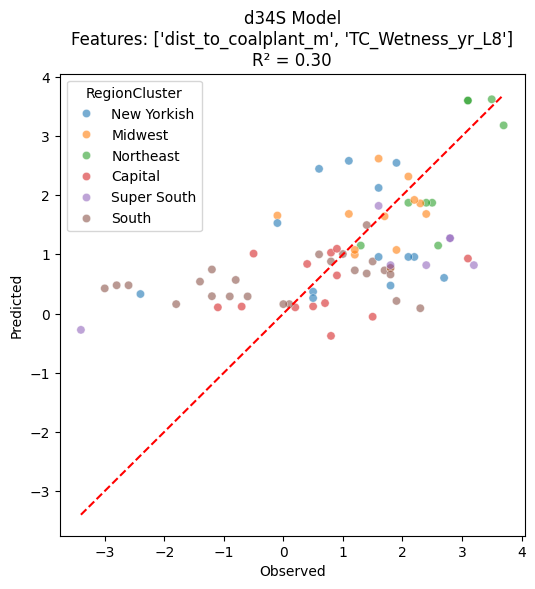

In [108]:
#plot pred vs obs

plt.figure(figsize=(6,6))
sns.scatterplot(
    data=tree,
    x='d34S',
    y="d34S_pred_with_['dist_to_coalplant_m', 'TC_Wetness_yr_L8']",
    hue='RegionCluster',   
    palette='tab10',     
    alpha=0.6
)

# 1:1 line
plt.plot([tree['d34S'].min(), tree['d34S'].max()],
         [tree['d34S'].min(), tree['d34S'].max()], 'r--')

plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title(f"{target} Model\nFeatures: {features}\nR² = {r2:.2f}")
plt.show()


In [111]:
#tree.tail(50)